In [1]:
#General imports.
import ROOT as r
import math
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
r.gStyle.SetOptStat(0)
r.gStyle.SetOptFit(1111)
import matplotlib.pyplot as plt
import csv
import pandas

import seaborn as sns
sns.set(style="ticks", color_codes=True)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
import os
import scipy

import uproot #https://indico.cern.ch/event/686641/contributions/2894906/attachments/1606247/2548596/pivarski-uproot.pdf
from awkward import JaggedArray
from root_pandas import read_root # https://github.com/scikit-hep/root_pandas

%matplotlib inline

Welcome to JupyROOT 6.12/06


In [2]:
f = r.TFile("./data/gm2offline_ana_version1.root")
twest = f.Get("farline").Get("eventTree")
teast = f.Get("farline").Get("eastTree")

In [3]:
twest.Print()

******************************************************************************
*Tree    :eventTree : eventTree                                              *
*Entries :       82 : Total =        13237183 bytes  File  Size =    9967739 *
*        :          : Tree compression factor =   1.33                       *
******************************************************************************
*Br    0 :runNum    : runNum/i                                               *
*Entries :       82 : Total  Size=        895 bytes  File Size  =        104 *
*Baskets :        1 : Basket Size=      32000 bytes  Compression=   3.90     *
*............................................................................*
*Br    1 :subRunNum : subRunNum/i                                            *
*Entries :       82 : Total  Size=        910 bytes  File Size  =        107 *
*Baskets :        1 : Basket Size=      32000 bytes  Compression=   3.82     *
*...................................................

In [4]:
teast.Print()

******************************************************************************
*Tree    :eastTree  : eastTree                                               *
*Entries :   274505 : Total =        44170879 bytes  File  Size =   19871069 *
*        :          : Tree compression factor =   2.22                       *
******************************************************************************
*Br    0 :runNum    : runNum/i                                               *
*Entries :   274505 : Total  Size=    1101724 bytes  File Size  =       9358 *
*Baskets :       35 : Basket Size=      32000 bytes  Compression= 117.62     *
*............................................................................*
*Br    1 :subRunNum : subRunNum/i                                            *
*Entries :   274505 : Total  Size=    1101841 bytes  File Size  =       9427 *
*Baskets :       35 : Basket Size=      32000 bytes  Compression= 116.77     *
*...................................................

In [5]:
#These are magic numbers which were stolen from https://cdcvs.fnal.gov/redmine/projects/gm2reconeast/repository/revisions/develop/entry/analyses/ReconstructionComparison_module.cc
#Will need to figure out where they come from
reconEastCaloTimeCorrection = [-2.052, -2.352, -2.255, -2.244, -0.117, 0.707,  0.312,  0.064,
                                -0.542, -0.365, -0.641, -0.779,  0.158, 0.052, -0.370, -0.181,
                                -0.705, -0.945, -0.861, -0.851, -0.154, 0.000, -0.417,  0.218]
#recon east energy fudge factor
energyFudgeFactor = 1.10

Beginning entry: 0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TFile::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hpos (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TFile::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hpos (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TFile::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hpos (Potential memory leak).


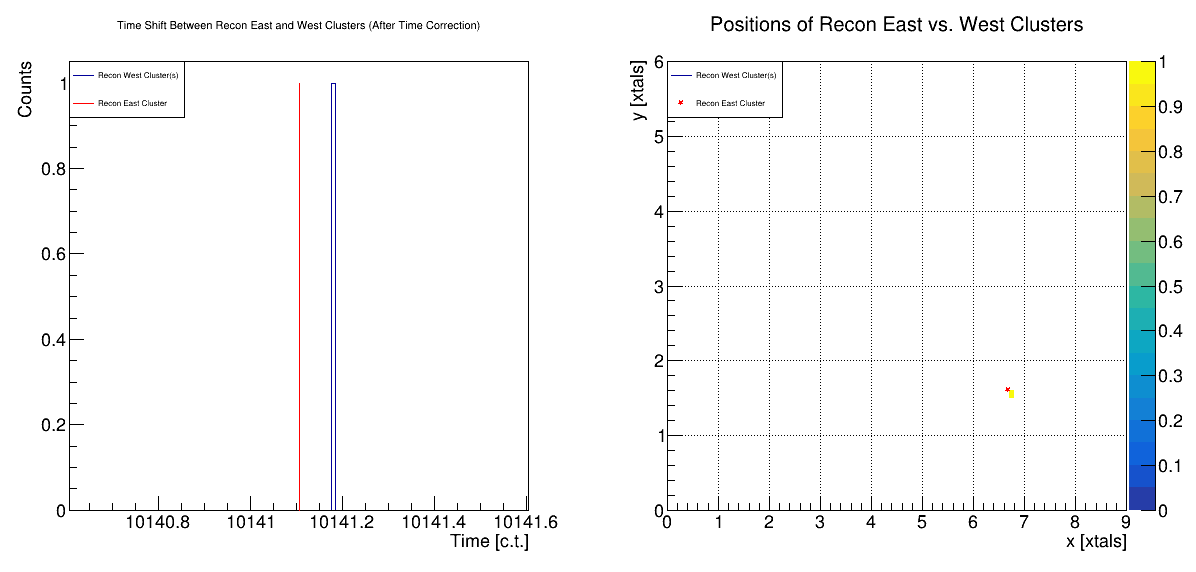

In [26]:
matchingClusterCounts = []
positionsVec = []
timesVec = []
energyVec = []
caloNumVec = []
errorVec = []

for i,entry in enumerate(teast):
    if (i % 500 == 0):
        print("Beginning entry:",i)
    if i > 2: 
        break
#    print("Beginning entry", i)
#    print("     Time, Energy:", entry.time,entry.energy)
#    print("     Positions: ", entry.position.first,entry.position.second)
#    print("     CaloNum:", entry.calorimeterIndex)
    c = r.TCanvas("c","c",1200,600)
    c.Divide(2)
    c.cd(1)
    
    timecorrection = reconEastCaloTimeCorrection[entry.calorimeterIndex - 1]
#    timecorrection = newTimeCorrection[entry.calorimeterIndex - 1]
    cut = "eventNum == "+str(entry.fillIndex) +" && caloNum == "+str(entry.calorimeterIndex)+" && time < "+str(entry.time - timecorrection + 0.5 ) + " && time > " + str(entry.time - timecorrection - 0.5)
    #curring on fill number, run/subrun number (implicitly by file), and time only
    
    h = r.TH1D("h","Time Shift Between Recon East and West Clusters (After Time Correction); Time [c.t.]; Counts",
               1000,entry.time-5,entry.time+5)
    
    twest.Draw("time + "+str(timecorrection)+">>h", cut ,"goff")
    h.GetXaxis().SetRangeUser(entry.time-0.5,entry.time+0.5)
    h.Draw()
#    print("    ",h.GetEntries(),"Clusters within this time range")
    if(h.GetEntries() != 1):
        print("ERROR: MORE/LESS THAN ONE MATCHING CLUSTER (", h.GetEntries()," found )")
        errorVec.append((h.GetEntries(), i, entry.calorimeterIndex))
        continue
    matchingClusterCounts.append( h.GetEntries() )
    
    eastmarker = r.TLine((entry.time),0,(entry.time),1)
    eastmarker.SetLineColor(2)
    eastmarker.Draw()
    
    h.GetXaxis().SetNdivisions(505)
    

    leg = r.TLegend(0.1,0.8,0.3,0.9)
    leg.AddEntry(h ,"Recon West Cluster(s)", "l")
    leg.AddEntry(eastmarker ,"Recon East Cluster", "l")
    leg.Draw()
    
    c.cd(2)
    hpos = r.TH2D("hpos","Positions of Recon East vs. West Clusters; x [xtals]; y [xtals]",90,0,9,60,0,6)
    twest.Draw("y:x>>hpos",cut,"goff")    
    r.gPad.SetGridx()
    r.gPad.SetGridy()
    hpos.Draw("COLZ")
    
    poseast = r.TMarker(entry.position.first,entry.position.second,29)
    poseast.SetMarkerColor(2)
    poseast.Draw("SAME")
    
    leg2 = r.TLegend(0.1,0.8,0.3,0.9)
    leg2.AddEntry(hpos ,"Recon West Cluster(s)", "l")
    leg2.AddEntry(poseast ,"Recon East Cluster", "p")
    leg2.Draw()
    
    positionsVec.append( ( entry.position.first , entry.position.second , (twest.GetV1())[0] , (twest.GetV2())[0] ) )
    
    c.Draw()
    
    twest.Draw("time:energy",cut,"goff")
    
    timesVec.append( ( entry.time - timecorrection , twest.GetV1()[0] ) )
    energyVec.append( ( entry.energy , twest.GetV2()[0] ) )
    caloNumVec.append( entry.calorimeterIndex )
    

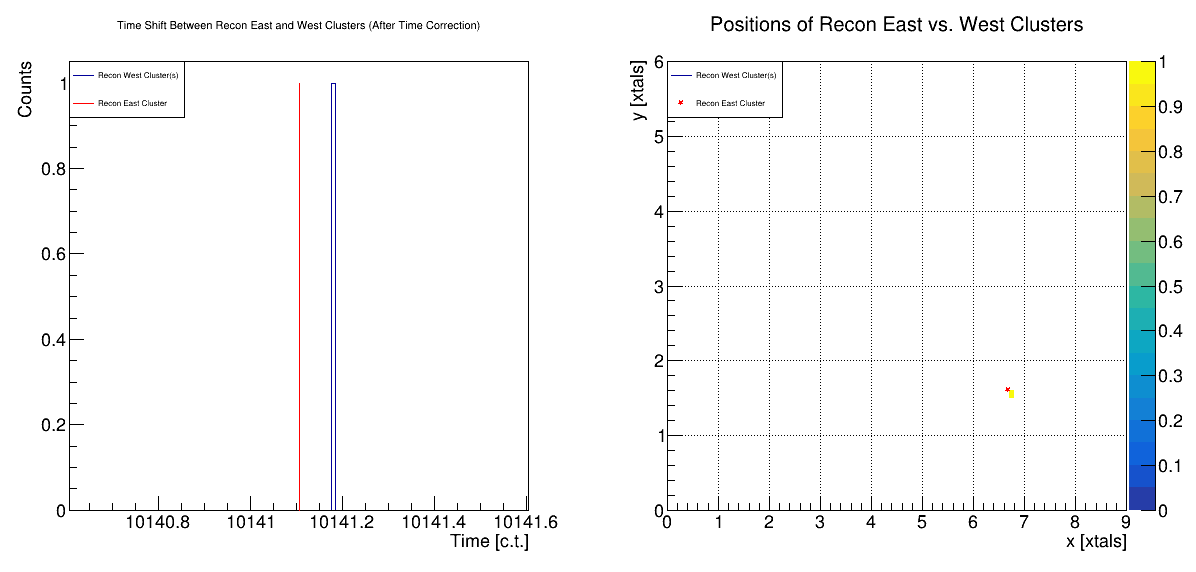

In [27]:
c.Draw()

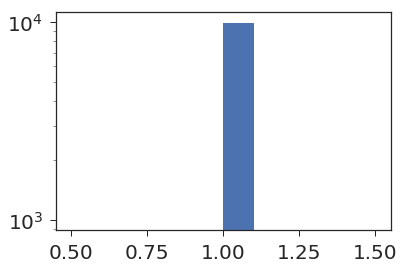

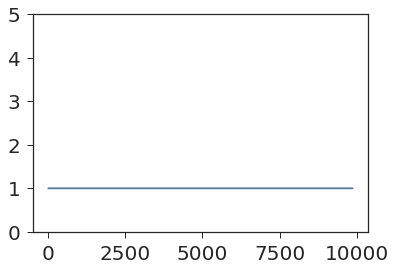

In [147]:
plt.hist(matchingClusterCounts)
plt.yscale("log")
plt.show()
plt.plot(matchingClusterCounts)
plt.ylim(0,5)
plt.show()

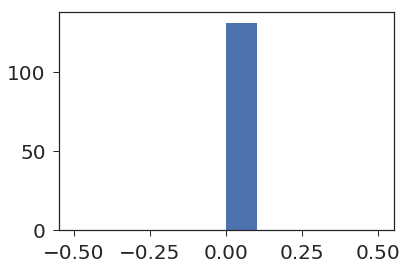

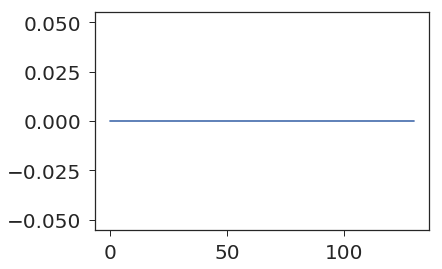

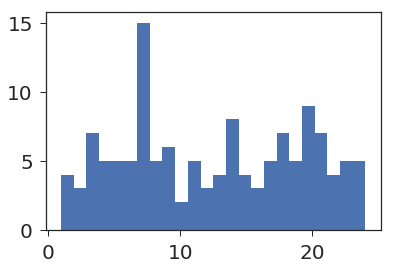

In [148]:
if(len(errorVec)>0):
    errorCounts, errorI, errorCalo = zip(*errorVec)

    plt.hist(errorCounts)
    plt.show()
    plt.plot(errorCounts)
    plt.show()
    plt.hist(errorCalo,bins=24)
    plt.show()
else:
    print("No Errors")

In [149]:
vecXeast, vecYeast, vecYwest, vecXwest = zip(*positionsVec)

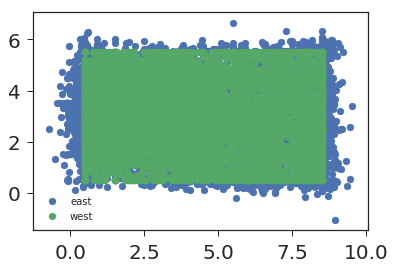

In [150]:
plt.scatter(vecXeast,vecYeast,label='east')
plt.scatter(vecXwest,vecYwest,label='west')
plt.legend()
plt.show()

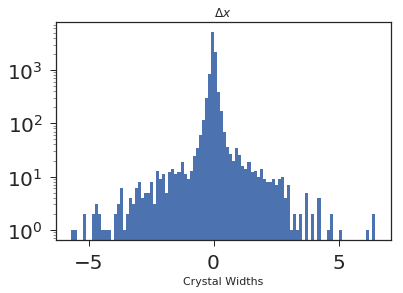

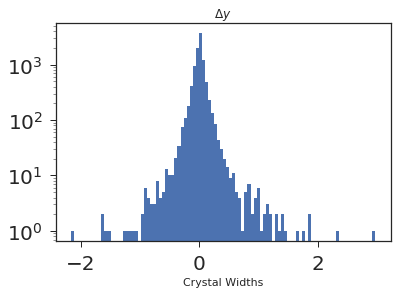

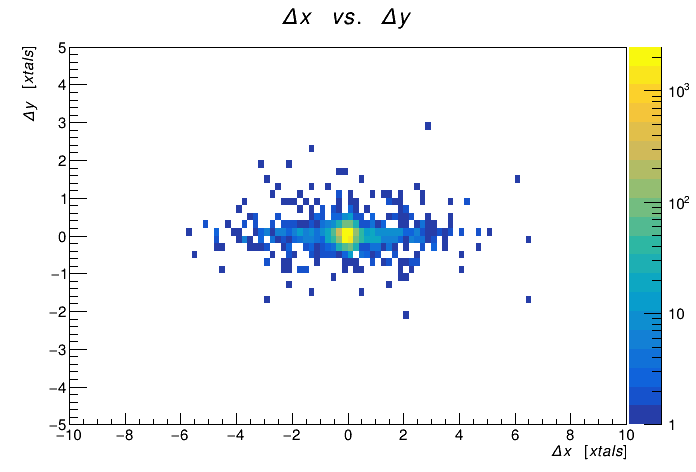

In [151]:
deltaX = []
deltaY = []
for xeast, yeast, ywest, xwest in positionsVec:
    deltaX.append( xeast - xwest )
    deltaY.append( yeast - ywest )
    
plt.hist(deltaX,bins=100)
plt.title("$\Delta x$")
plt.xlabel("Crystal Widths")
plt.yscale("log")
plt.show()

plt.hist(deltaY,bins=100)
plt.title("$\Delta y$")
plt.xlabel("Crystal Widths")
plt.yscale("log")
plt.show()

'''
cmap = plt.get_cmap("viridis")
cmap.set_bad("white")
cmap.set_under("white")

plt.hist2d(deltaX,deltaY,bins=20,cmap=cmap,vmin=0.1)
plt.xlabel("$\Delta x$")
plt.ylabel("$\Delta y$")
plt.colorbar()
plt.show()
'''
c2 = r.TCanvas()
hdeltaxy = r.TH2D("hdeltaxy","$\Delta x ~vs.~ \Delta y$; $\Delta x$ [xtals]; $\Delta y$ [xtals]"
                  ,100,-10,10,50,-5,5)
for i,x in enumerate(deltaX):
    hdeltaxy.Fill(x,deltaY[i])
hdeltaxy.Draw("COLZ")
c2.SetLogz()
c2.Draw()

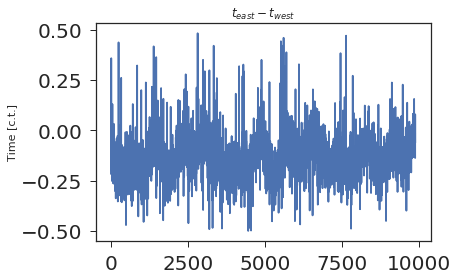

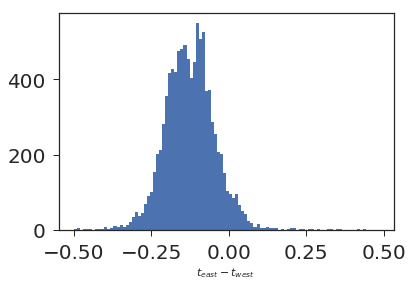

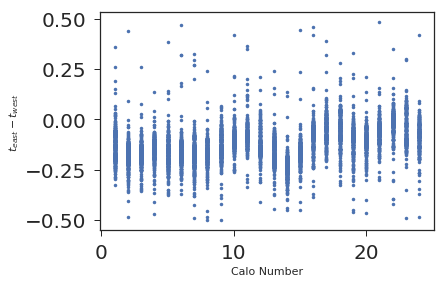

In [152]:
deltaT = [x[0] - x[1] for x in timesVec]
plt.plot(deltaT)
plt.title("$t_{east} - t_{west}$")
plt.ylabel("Time [c.t.]")
plt.show()

plt.hist(deltaT,bins=100)
plt.xlabel("$t_{east} - t_{west}$")
plt.show()

plt.plot(caloNumVec,deltaT,'.')
plt.xlabel("Calo Number")
plt.ylabel("$t_{east} - t_{west}$")
plt.show()

In [153]:
#Now lets assemble a new group of time correction factors
df = pandas.DataFrame({"caloNum":caloNumVec,"deltat":deltaT})
df.head()
newTimeCorrection = []
for i in range(1,25):
    dfi = df.loc[df['caloNum'] == i]
    meandeltat = dfi['deltat'].mean()
    if(math.isnan(meandeltat)):
        meandeltat = 0
    
    newTimeCorrection.append( meandeltat + reconEastCaloTimeCorrection[i-1] )
    
print(newTimeCorrection)

[-2.184670839793411, -2.533534539833983, -2.4305517319263825, -2.3928086583541712, -0.282764010404635, 0.5433259587725806, 0.14146069749596443, -0.1005426611310247, -0.6780972456958365, -0.46174148424802247, -0.7222922290542133, -0.9087601679544991, -0.0020242443022461254, -0.18444488364280662, -0.5393264236058275, -0.26269334980000014, -0.7608673288815626, -0.9998406340192157, -0.9552652436611244, -0.955093218032966, -0.2153816819021083, -0.01722456114763456, -0.46497879073769843, 0.13440468703900985]


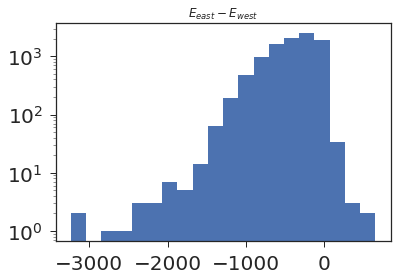

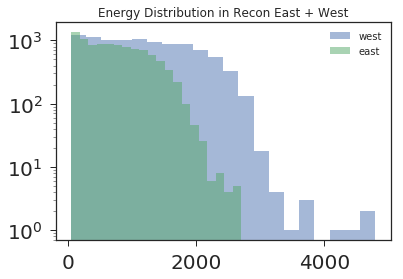

In [154]:
deltaE = [x[0] - x[1] for x in energyVec]
eeast, ewest = zip(*energyVec)
plt.hist(deltaE,bins=20)
plt.title("$E_{east} - E_{west}$")
plt.yscale("log")
plt.show()

plt.hist(ewest, alpha=0.5,bins=20,label='west')
plt.hist(eeast, alpha=0.5,bins=20,label='east')
plt.title("Energy Distribution in Recon East + West")
plt.yscale("log")
plt.legend()
plt.show()

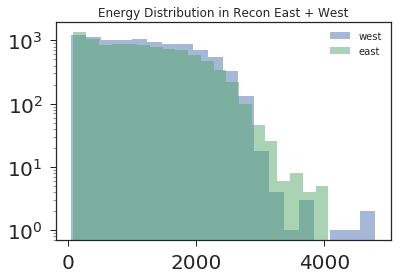

In [155]:
plt.hist(ewest, alpha=0.5,bins=20,label='west')
plt.hist([eeasti*1.5 for eeasti in eeast], alpha=0.5,bins=20,label='east')
plt.title("Energy Distribution in Recon East + West")
plt.yscale("log")
plt.legend()
plt.show()

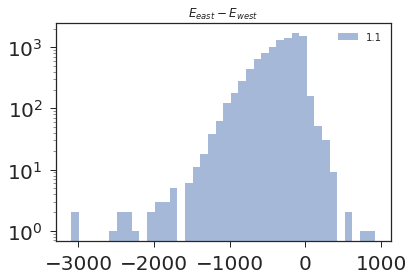

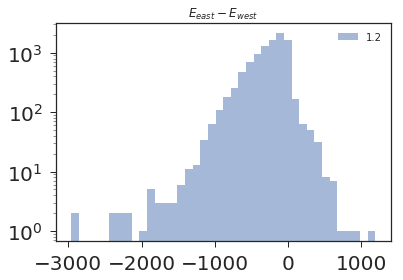

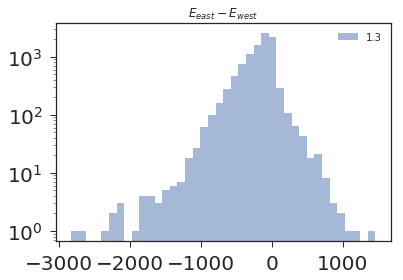

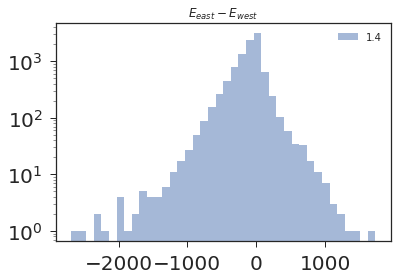

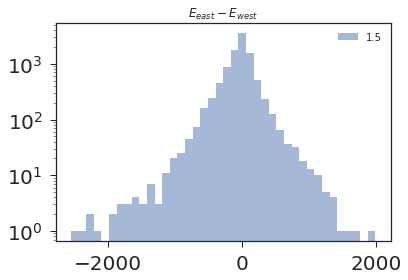

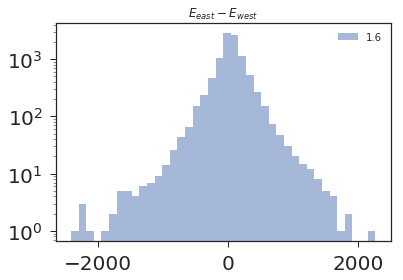

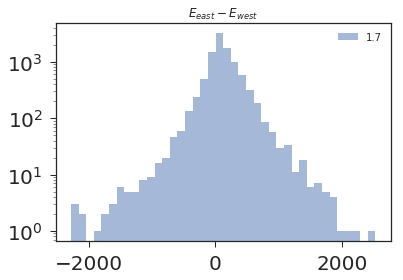

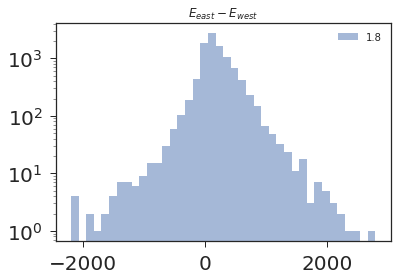

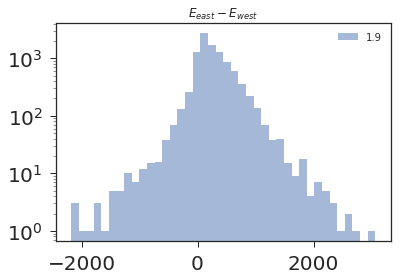

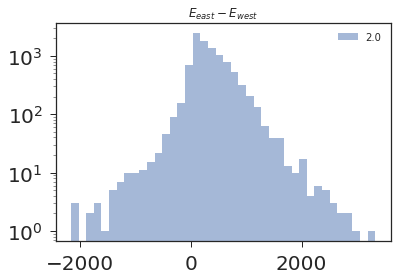

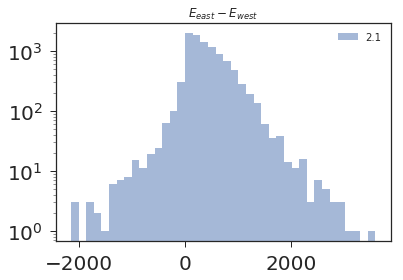

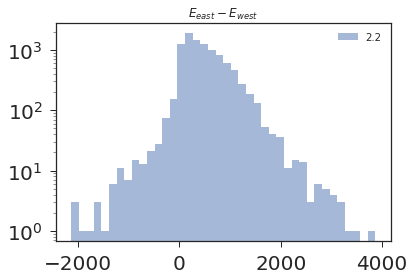

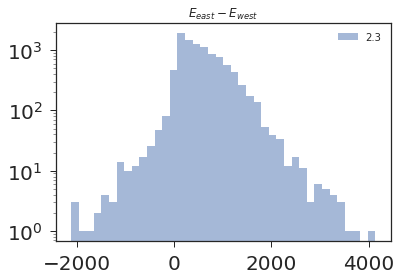

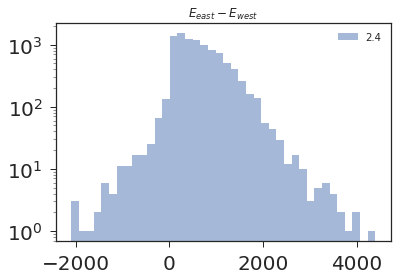

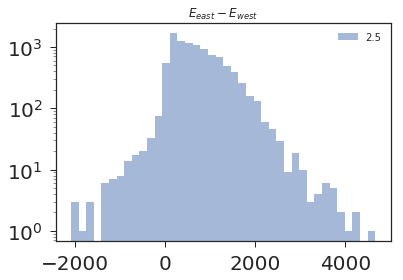

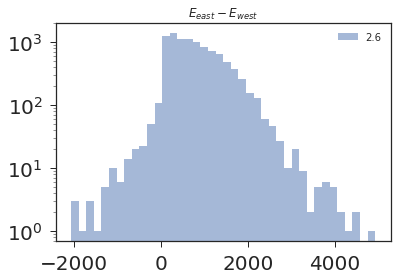

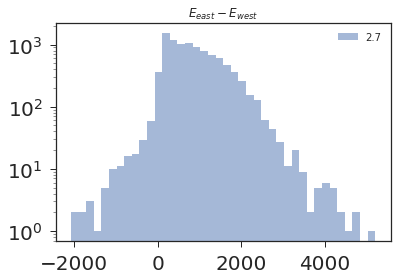

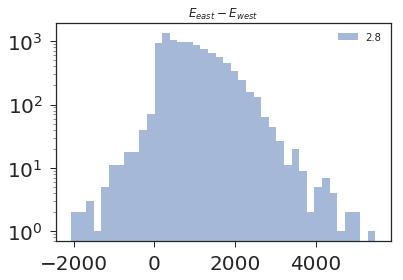

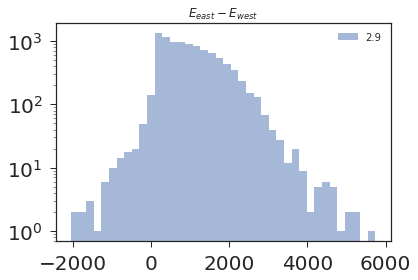

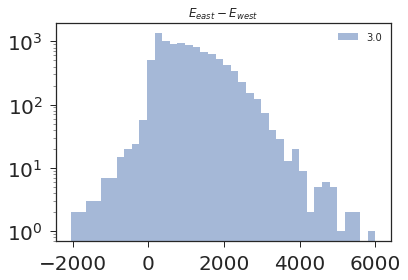

In [156]:
for factor in range(11,31):
    eeastCorr = [eeasti*(factor/10.) for eeasti in eeast]
    deltaEcorr = [eeastCorr[i] - x[1] for i,x in enumerate(energyVec)]
    plt.hist(deltaEcorr,bins=40,label=str(factor/10.),alpha=0.5)
    plt.title("$E_{east} - E_{west}$")
    plt.legend()
    plt.yscale("log")
    plt.show()